In [1]:
#Importing Data from the CSV file
%matplotlib inline
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
from cvxopt import matrix as cvxopt_matrix
from cvxopt import solvers as cvxopt_solvers
from sklearn.svm import SVC as svc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
import seaborn as sns
import time
from scipy import spatial
from itertools import combinations 
import pickle

28*28 - one row size = 784 - one training data

In [2]:
def input_read(file, sep, class0=None, class1=None):
    myFile = pd.read_csv(file, sep=sep, header=None, index_col=False)
    if ((class0!=None) and (class1!=None)):
        df_train = myFile[(myFile.get(784) == class0) | (myFile.get(784) == class1)]
    else: df_train = myFile
    train_classes = df_train[784]
    if ((class0!=None) and (class1!=None)):
        train_classes = (train_classes.apply(lambda x: 1 if (x==class1) else -1))*1.
    train_classes.index = np.arange(0, len(df_train))
    df_train = df_train.drop(784, axis=1)
    df_train.index=(np.arange(0, len(df_train)))
    df_train /= 255
    return df_train.to_numpy(), train_classes.to_numpy();

In [3]:
def calc_accuracy(classes, pred_classes):   
    acc = 0
    for i in range(len(classes)):
        if (classes[i]==pred_classes[i]):
            acc+=1
    acc = (acc/len(classes))*100
    return acc

In [4]:
def gauss_kernel_cvxopt(X_train, train_classes, c=1):
    sv_pos_ind=[]
    sv_neg_ind=[]
    start =time.time()
    m,n = X_train.shape
    K = np.zeros((m,m))
    gamma = 0.05
    start = time.time()
    pdist = spatial.distance.pdist(X_train, 'sqeuclidean')
    K = np.exp(-1*gamma*spatial.distance.squareform(pdist))
    end = time.time()
    print("Time to Calculate Gaussian Kernel matrix for CVXOPT= {}s".format(end-start))

    P = cvxopt_matrix(np.outer(train_classes, train_classes)*K)
    q = cvxopt_matrix(-1*np.ones((m,1)))
    G1 =-1*np.eye(m)
    G2 =c*np.eye(m)
    G = cvxopt_matrix(np.vstack((G1,G2)))
    h1 = np.zeros(m)
    h2 = np.ones(m)*c
    h = cvxopt_matrix(np.hstack((h1,h2)))
    A = cvxopt_matrix(train_classes.reshape(1,-1)*1.)
    b = cvxopt_matrix(np.zeros(1))
    cvx_solver = cvxopt_solvers.qp(P, q, G, h, A, b)
    print("The time taken to optimize SVM model using CVXOPT and Gaussian Kernel = {}sec".format(time.time()-start))    

    return cvx_solver;

In [5]:
def train_classifiers(X_train, train_classes, class1, class2):
    
    train_classes = train_classes.reshape(-1,1)
    m,n = X_train.shape
    c=1 #penalty weight
    print("Running CVX Optimizer to classify Class {} and Class {} with Gaussian Kernel".format(class1, class2))
    print("--------------------TRAINING--------------------------------------------")
    
    cvx_solver = gauss_kernel_cvxopt(X_train, train_classes, c)
    return cvx_solver

In [6]:
def predict(X_train, X_val, X_test, train_classes, val_classes, test_classes, w, b, kernel_shape, supp_vec_ind, alpha):
    if(kernel_shape == 'linear'):
        train_pred = [1.0 if x >=0 else -1. for x in (np.dot(X_train,w) + b) ]
        train_acc = calc_accuracy(train_classes, train_pred)

        val_pred = [1. if x >=0 else -1. for x in (np.dot(X_val,w) + b) ]
        val_acc = calc_accuracy(val_classes, val_pred)

        test_pred = [1. if x >=0 else -1. for x in (np.dot(X_test,w) + b) ]
        test_acc = calc_accuracy(test_classes, test_pred)
        
    elif(kernel_shape == 'gaussian'):
        cdist = spatial.distance.cdist(X_train[supp_vec_ind], X_train, 'sqeuclidean')
        K_train = np.exp(-1*0.05*(cdist))
        w = np.dot(K_train.T, (alpha[supp_vec_ind]*train_classes[supp_vec_ind]))
        train_pred = w + b
        
        cdist = spatial.distance.cdist(X_train[supp_vec_ind], X_val, 'sqeuclidean')
        K_val = np.exp(-1*0.05*(cdist))
        w = np.dot(K_val.T, (alpha[supp_vec_ind]*train_classes[supp_vec_ind]))
        val_pred = w + b
        
        cdist = spatial.distance.cdist(X_train[supp_vec_ind], X_test, 'sqeuclidean')
        K_test = np.exp(-1*0.05*(cdist))
        w = np.dot(K_test.T, (alpha[supp_vec_ind]*train_classes[supp_vec_ind]))
        test_pred = w + b
        
    return train_pred, val_pred, test_pred;

# 50 mins to train classifiers 

In [ ]:
label=range(10)
comb = combinations(label, 2) 
num_classifier=0
for i in list(comb): 
    num_classifier+=1
    
comb = combinations(label, 2) 

cvx_solver = []
print(num_classifier)

#Training all the classifiers per class pair
for k in list(comb):   
    X_train, train_classes = input_read('fashion_mnist/train.csv', ',', k[0], k[1])
    cvx_solver.append(train_classifiers(X_train, train_classes, k[0], k[1]))

45
Running CVX Optimizer to classify Class 0 and Class 1 with Gaussian Kernel
--------------------TRAINING--------------------------------------------
Time to Calculate Gaussian Kernel matrix for CVXOPT= 5.133698463439941s


In [ ]:
import pickle
with open('fashion_MNIST_SVM.pickle','wb') as f:
    pickle.dump(cvx_solver, f)

In [ ]:
cvx_solver = pickle.load(open("fashion_MNIST_SVM.pickle", "rb"))
print(cvx_solver)

In [7]:
X_val, val_classes = input_read('fashion_mnist/val.csv', ',')
X_test, test_classes = input_read('fashion_mnist/test.csv', ',')

In [194]:
classifiers = list(combinations(label, 2) )
#train_label_score = np.zeros((len(X_train), len(label)))
val_label_score = np.zeros((len(X_val), len(label)))
test_label_score = np.zeros((len(X_test), len(label)))

start = time.time()
for i in range(len(classifiers)):
    k = classifiers[i] # Stores class pair for the current classifier
    X_train, train_classes = input_read('fashion_mnist/train.csv', ',', k[0], k[1])
    print(k[0], k[1])
    train_classes = train_classes.reshape(-1,1)
    alpha = np.array(cvx_solver[i]['x'])
    S = (alpha > 1e-3)
    supp_vec_ind = np.where(S == True)[0]
    S = S.flatten()
    pdist = spatial.distance.pdist(X_train[supp_vec_ind], 'sqeuclidean')
    K_train = np.exp(-1*0.05*spatial.distance.squareform(pdist))
    w_train = np.dot(K_train.T, (alpha[S]*train_classes[S]))
    bias = train_classes[S] - w_train
    b = np.mean(bias)
    train_pred, val_pred, test_pred= predict(X_train, X_val, X_test, train_classes, val_classes, test_classes, w_train, b, 'gaussian', supp_vec_ind, alpha)    
    #train_pred = [k[1] if x >=0 else k[0] for x in train_pred ]
    
    class1=np.where(val_pred >=0)[0]
    class0=np.where(val_pred <0)[0]
    val_pred[class1] = 1/(1 + np.exp(-np.abs(val_pred[class1])))
    val_pred[class0] = 1/(1 + np.exp(-np.abs(val_pred[class0])))
    val_label_score[class1,k[1]]+=val_pred[class1,0]
    val_label_score[class0,k[0]]+=val_pred[class0,0]
    
    class1=np.where(test_pred >=0)[0]
    class0=np.where(test_pred <0)[0]
    test_pred[class1] = 1/(1 + np.exp(-np.abs(test_pred[class1])))
    test_pred[class0] = 1/(1 + np.exp(-np.abs(test_pred[class0])))
    test_label_score[class1,k[1]]+=test_pred[class1,0]
    test_label_score[class0,k[0]]+=test_pred[class0,0]

print("The time taken to predict the scores is {}sec".format(time.time()-start))

0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
2 3
2 4
2 5
2 6
2 7
2 8
2 9
3 4
3 5
3 6
3 7
3 8
3 9
4 5
4 6
4 7
4 8
4 9
5 6
5 7
5 8
5 9
6 7
6 8
6 9
7 8
7 9
8 9
The time taken to predict the scores is 438.2061915397644sec


In [237]:
val_label_pred = [np.where(x == max(x))[0][0] for x in val_label_score[:,:]]
test_label_pred  = [np.where(x == max(x))[0][0] for x in test_label_score[:,:]]
val_acc = calc_accuracy(val_classes, val_label_pred)
test_acc = calc_accuracy(test_classes, test_label_pred)
print(val_acc, test_acc)

87.6 87.8


[supp_vec_ind]#Implementation using SVM Classifier

In [242]:
print("\n-----------GAUSSIAN KERNEL----------------")
print("---------------CVXOPT---------------------")

print("The Validation accuracy of the model with 10C2 classifiers is= {:2.3f}%".format(val_acc))
print("The test accuracy of the model with 10C2 classifiers is = {:2.3f}%".format(test_acc))


-----------GAUSSIAN KERNEL----------------
---------------CVXOPT---------------------
The Validation accuracy of the model with 10C2 classifiers is= 87.600%
The test accuracy of the model with 10C2 classifiers is = 87.800%


# Read whole input training set for SVM classifier

In [8]:
X_train, train_classes = input_read('fashion_mnist/train.csv', ',')


In [9]:
def sklearn_svm(X_train, train_classes, shape, gamma='scale'):
    start = time.time()
    svc_classifier = svc(kernel=shape, gamma=gamma, decision_function_shape='ovo')
    svc_classifier.fit(X_train, train_classes)
    train_pred_svc = svc_classifier.predict(X_train)
    val_pred_svc = svc_classifier.predict(X_val)
    test_pred_svc = svc_classifier.predict(X_test)
    train_acc_svc = svc_classifier.score(X_train, train_classes)
    val_acc_svc = svc_classifier.score(X_val, val_classes)
    test_acc_svc = svc_classifier.score(X_test, test_classes)
    print("The time taken to train SVM model using SVM classifier SKLEARN and {} Kernel = {}sec"
          .format(shape, time.time()-start))    
    print("The number of support vectors in SVM classifier trained model with {} kernel = {}"
          .format(shape, svc_classifier.n_support_))
    return train_pred_svc, val_pred_svc, test_pred_svc, train_acc_svc, val_acc_svc, test_acc_svc;

In [10]:
print("Running SVM Classifier from SKLEARN to classify with Gaussian Kernel")
print("--------------------TRAINING--------------------------------------------")
train_pred_svc, val_pred_svc, test_pred_svc, train_acc_svc, val_acc_svc, test_acc_svc= sklearn_svm(X_train, train_classes, 'rbf', 0.05)

print("-----------SVM classifier--------------")

#print("The number of support vectors are = {}".format())
print("The training accuracy of the SVM model is = {:2.3f}%".format(train_acc_svc*100))
print("The Validation accuracy of the SVM model is= {:2.3f}%".format(val_acc_svc*100))
print("The test accuracy of the SVM model is = {:2.3f}%".format(test_acc_svc*100))

Running SVM Classifier from SKLEARN to classify with Gaussian Kernel
--------------------TRAINING--------------------------------------------
The time taken to train SVM model using SVM classifier SKLEARN and rbf Kernel = 1159.4606883525848sec
The number of support vectors in SVM classifier trained model with rbf kernel = [1291  368 1543 1144 1541 1282 1832  770 1078  816]
-----------SVM classifier--------------
The training accuracy of the SVM model is = 96.920%
The Validation accuracy of the SVM model is= 87.920%
The test accuracy of the SVM model is = 88.080%


In [11]:
def plot_conf_matrix(kernel_shape, test_classes, test_pred, test_pred_svc ):
    print("\nPlotting Confusion Matrix for {} Kernel - CVXOPT vs. SVMC-library".format(kernel_shape))

    conf_matrix_cvxopt = confusion_matrix(test_classes, test_pred)
    conf_matrix_svmC = confusion_matrix(test_classes, test_pred_svc)
    fig = plt.figure()
    ax= fig.add_subplot(221)
    sns.heatmap(conf_matrix_cvxopt, annot=True, ax = ax, fmt="d",linewidths=1, cmap="YlGnBu"); #annot=True to annotate cells
    ax.set_ylim([0,2]) # Workaround to display values in the center, to avoid downgrade to matplotlib3.1.1
    ax.set_ylabel('Actual labels');
    ax.set_xlabel('Predicted labels'); 
    ax.set_title('Confusion Matrix with CVX '); 
    ax.xaxis.set_ticklabels(['y=0', 'y=1']); ax.yaxis.set_ticklabels(['y=0', 'y=1']);

    ax1 = fig.add_subplot(222)
    sns.heatmap(conf_matrix_svmC, annot=True, ax = ax1, fmt="d",linewidths=1, cmap="YlGnBu"); #annot=True to annotate cells
    ax1.set_ylim([0,2]) # Workaround to display values in the center, to avoid downgrade to matplotlib3.1.1
    ax1.set_ylabel('Actual labels');
    ax1.set_xlabel('Predicted labels'); 
    ax1.set_title('Confusion Matrix with SVM-C'); 
    ax1.xaxis.set_ticklabels(['y=0', 'y=1']); ax1.yaxis.set_ticklabels(['y=0', 'y=1']);

    fig.tight_layout(pad=3.0)

    plt.show()

In [12]:
plot_conf_matrix('gaussian', test_classes, test_label_pred, test_pred_svc)

NameError: name 'test_label_pred' is not defined


Plotting Confusion Matrix for linear Kernel - CVXOPT vs. SVMC-library


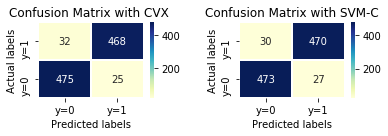

In [16]:
#Print confusion matrix (Code help from stackoverflow)
plot_conf_matrix('linear', test_classes, test_pred, test_pred_svc)

Plotting comparison plots


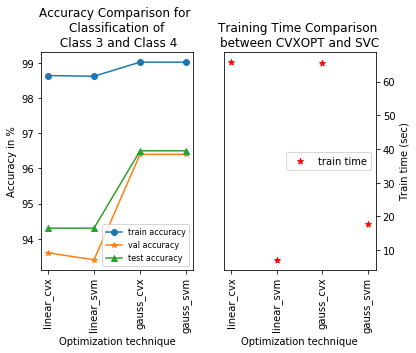

In [28]:
#Data Plot
print("Plotting comparison plots")

data = ["","linear_cvx","linear_svm", "gauss_cvx", "gauss_svm"]
train_acc = [98.64, 98.62, 99.022, 99.02]
val_acc = [93.6, 93.4, 96.4, 96.4]
test_acc = [94.3, 94.3, 96.5, 96.5]
runtime = [65.74,  7.12, 65.45 , 17.77]
sv_num =[493, 493, 1259, 1259]
neg_sv =[259, 259, 627, 627]
pos_sv=[234, 234, 632, 632]

x = range(4)
fig = plt.figure()
ax = fig.add_subplot(121)
ax.plot(x, train_acc, marker='o', label='train accuracy')
ax.plot(x, val_acc, marker='*', label='val accuracy')
ax.plot(x, test_acc, marker='^', label='test accuracy')
ax.set_ylabel('Accuracy in %')
ax.set_xlabel('Optimization technique')
ax.set_title('Accuracy Comparison for \nClassification of\n Class 3 and Class 4')
ax.set_xticklabels(data, rotation = 90)
ax.legend(loc="lower right", fontsize=8)
ax1=fig.add_subplot(122)
ax1.scatter(x, runtime, marker='*', c='r', label='train time')
ax1.legend(loc='center right')
ax1.set_ylabel('Train time (sec)')
ax1.set_xlabel('Optimization technique')
ax1.set_title('Training Time Comparison \nbetween CVXOPT and SVC')
ax1.set_xticklabels(data, rotation = 90)
ax1.yaxis.set_label_position("right")
ax1.yaxis.tick_right()
#plt.savefig('accuracy_traintime_comp.png', dpi=1000, bbox_inches='tight')
plt.show()

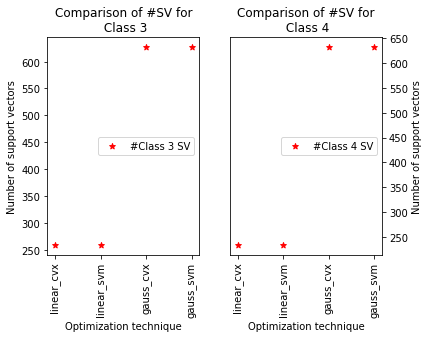

In [29]:
fig1=plt.figure()
ax2 = fig1.add_subplot(121)
ax2.scatter(x, neg_sv, marker='*', c='r', label='#Class 3 SV')
ax2.set_ylabel('Number of support vectors')
ax2.set_xlabel('Optimization technique')
ax2.set_title('Comparison of #SV for\n Class 3')
ax2.set_xticklabels(data, rotation = 90)
ax2.legend()
ax3 = fig1.add_subplot(122)
ax3.scatter(x, pos_sv,marker='*', c='r', label='#Class 4 SV')
ax3.set_ylabel('Number of support vectors')
ax3.set_xlabel('Optimization technique')
ax3.set_title('Comparison of #SV for\n Class 4')
ax3.set_xticklabels(data, rotation = 90)
ax3.yaxis.set_label_position("right")
ax3.yaxis.tick_right()
ax3.legend()
#plt.savefig('supp_vec.png', dpi=1000, bbox_inches='tight')

plt.show()

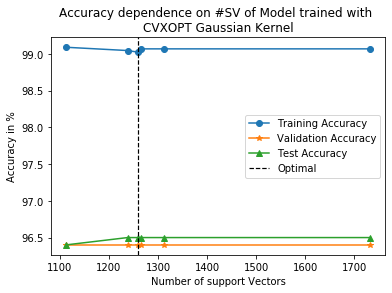

In [31]:
#variance with number of SV
fig=plt.figure()
ax = fig.add_subplot(111)
sv = [1112, 1238, 1259, 1265, 1312, 1732]
gaus_train_acc = [99.089,99.044 ,99.022,99.067,99.067,99.067]
gaus_val_acc =[96.4,96.4,96.4,96.4,96.4,96.4]
gaus_test_acc =[96.4,96.5,96.5,96.5,96.5,96.5]
ax.plot(sv, gaus_train_acc, marker='o', label='Training Accuracy')
ax.plot(sv, gaus_val_acc, marker='*', label='Validation Accuracy')
ax.plot(sv, gaus_test_acc, marker='^', label='Test Accuracy')
ax.axvline(x=1259, linestyle='--', linewidth=1.2, c='k', label='Optimal')
ax.set_xlabel('Number of support Vectors')
ax.set_ylabel('Accuracy in %')
ax.set_title("Accuracy dependence on #SV of Model trained with \nCVXOPT Gaussian Kernel")
ax.legend()
#ax.savefig('acc_sv_num_gaus.png', dpi=1000, bbox_inches='tight')
plt.show()

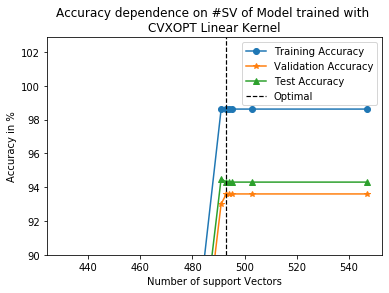

In [33]:
sv = [430, 491, 493, 494, 495, 503, 547]
gaus_train_acc = [15.37, 98.6, 98.64, 98.62, 98.62, 98.62, 98.62]
gaus_val_acc =[14.2, 93.0,93.6,93.6,93.6,93.6,93.6]
gaus_test_acc =[15.4,94.5,94.3,94.3,94.3,94.3,94.3]

fig=plt.figure()
ax = fig.add_subplot(111)
ax.plot(sv, gaus_train_acc, marker='o', label='Training Accuracy')
ax.plot(sv, gaus_val_acc, marker='*', label='Validation Accuracy')
ax.plot(sv, gaus_test_acc, marker='^', label='Test Accuracy')
ax.axvline(x=493, linestyle='--', linewidth=1.2, c='k', label='Optimal')
ax.set_ylim(bottom=90)
ax.set_xlabel('Number of support Vectors')
ax.set_ylabel('Accuracy in %')
ax.set_title("Accuracy dependence on #SV of Model trained with \nCVXOPT Linear Kernel")
ax.legend()
#ax.savefig('acc_sv_num_linear.png', dpi=1000, bbox_inches='tight')
plt.show()